Реализовать синтезирование лиц из LFW с помощью DCGAN

In [28]:
import numpy as np
import os

%matplotlib inline
import matplotlib.pyplot as plt
import time

import tensorflow as tf
import tensorflow_datasets as tfds

import warnings
warnings.filterwarnings('ignore')

## Загрузка и подготовка датасета LFW

In [29]:
(train_ds, test_ds), ds_info = tfds.load(
    'lfw', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'],
)

In [30]:
len(train_ds), len(test_ds)

(11910, 1323)

## Визуализация датасета LFW

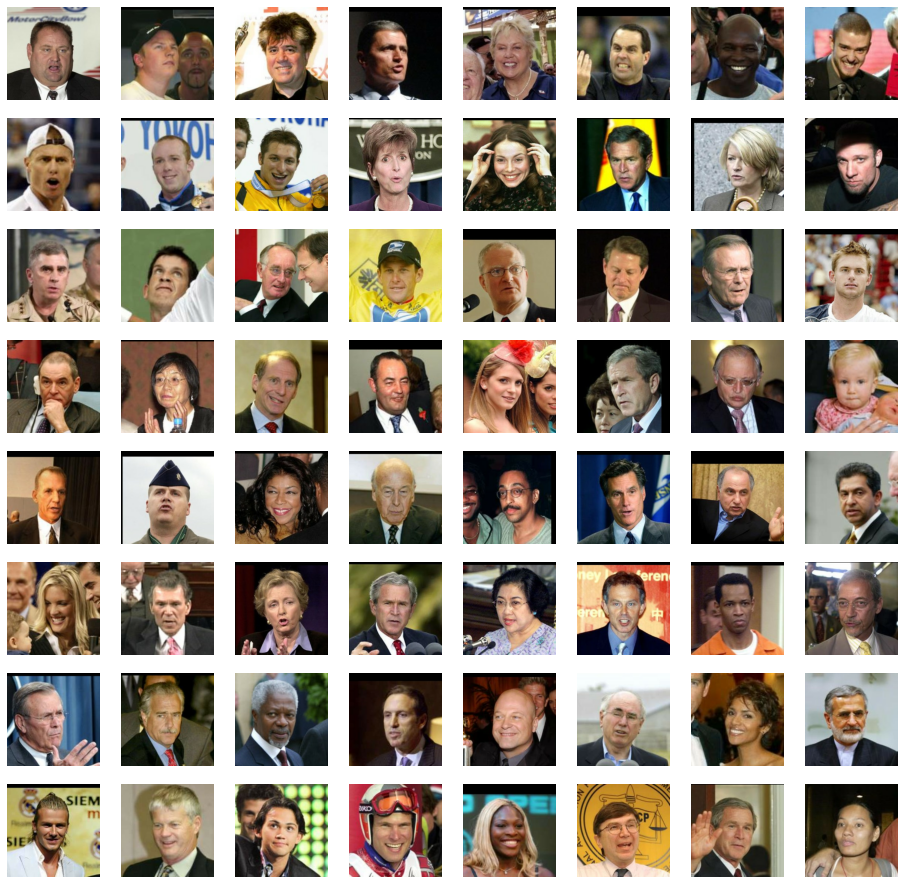

In [31]:
plt.figure(figsize=(16, 16))
for j, (label, image) in enumerate(train_ds.take(64)):
    plt.subplot(8, 8, j+1)
    plt.imshow(image)
    plt.axis('off')

## Подготовка пайплайна данных и оптимизатора

In [32]:
INPUT_DIM = 128
NUM_EPOCHS = 20

IMG_SIZE = 128
HALF_BATCH_SIZE = 10
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0002

train_ds = train_ds.shuffle(buffer_size=len(train_ds))
train_ds = train_ds.map(prepare)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

In [33]:
def prepare(label, img):
    img = tf.cast(img, tf.float32) / 255.
    return tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

## Deep Convolutional GAN (DCGAN)

In [41]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(128*32*32),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.ReLU(0.2),
    tf.keras.layers.Reshape((32, 32, 128)),
    tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(0.2),
    tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(0.2),   
    tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid'),
])


discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),  
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=2, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

# Обучение

In [42]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [43]:
def plot_results(samples):
    fig = plt.figure(figsize=(10, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        ax.imshow((samples[j, ...].reshape(IMG_SIZE, IMG_SIZE, 3)))
        plt.xticks([]),
        plt.yticks([])
    plt.show()

[Step  0] D Loss: 1.1144; G Loss: 0.7228; time taken ----> 1028.08 sec


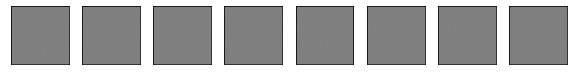

In [ ]:
%%time

for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    
    if (step % 1000 == 0):
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f;' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()), f'time taken ----> {round((time.time()-start), 2)} sec')
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise) 
        plot_results(syntetic_images)

## Тестирование свёрточного генератора

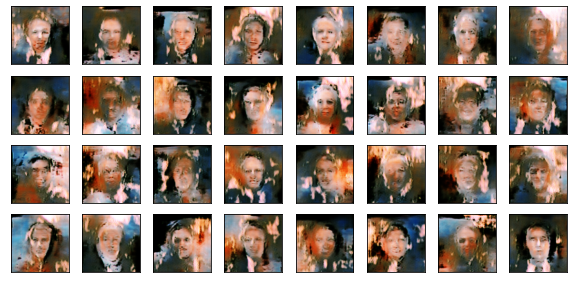

In [38]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_results(syntetic_images)

## Интерполяция в латентном пространстве

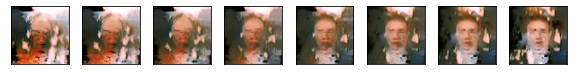

In [39]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_results(syntetic_images)